### 파이토치로 구현하는 신경망

#### 신경망 모델 구현

In [1]:
import torch
import numpy
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [2]:
n_dim = 2
x_train, y_train = make_blobs(n_samples=80, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)
x_test, y_test = make_blobs(n_samples=20, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)

In [3]:
def label_map(y_, from_, to_):
    y = numpy.copy(y_)
    for f in from_:
        y[y_ == f] = to_
    return y

y_train = label_map(y_train, [0, 1], 0)
y_train = label_map(y_train, [2, 3], 1)
y_test = label_map(y_test, [0, 1], 0)
y_test = label_map(y_test, [2, 3], 1)

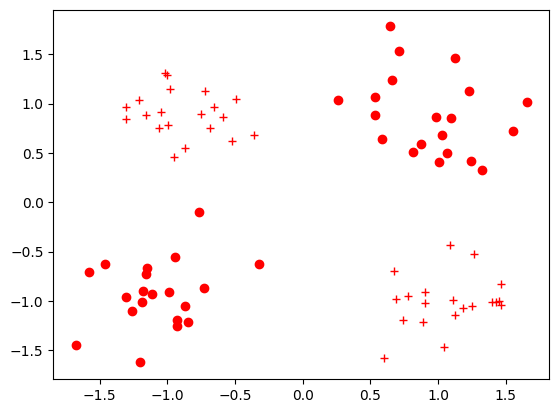

In [6]:
def vis_data(x,y = None, c = 'r'):
    if y is None:
        y = [None] * len(x)
    for x_, y_ in zip(x,y):
        if y_ is None:
            plt.plot(x_[0], x_[1], '*', markerfacecolor='none', markeredgecolor=c)
        else:
            plt.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')

plt.figure()
vis_data(x_train, y_train, c='r')
plt.show()

In [7]:
x_train = torch.FloatTensor(x_train)
print(x_train.shape)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

torch.Size([80, 2])


#### 모델 생성

In [8]:
class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, input_tensor):
        linear1 = self.linear_1(input_tensor)
        relu = self.relu(linear1)
        linear2 = self.linear_2(relu)
        output = self.sigmoid(linear2)
        return output

In [9]:
model = NeuralNet(2, 5)
learning_rate = 0.03
criterion = torch.nn.BCELoss()
epochs = 2000
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [11]:
model.eval()
test_loss_before = criterion(model(x_test).squeeze(), y_test)
print('Before Training, test loss is {}'.format(test_loss_before.item()))

Before Training, test loss is 0.7566312551498413


- 오차값이 0.77. 이 모델은 사실상 분류하는 능력이 없는 것
- 인공신경망을 학습시켜 퍼포먼스 올릴 예정

In [17]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_output = model(x_train)
    train_loss = criterion(train_output.squeeze(), y_train)

    if epoch % 100 == 0:
        print('Train loss at {} is {}'.format(epoch, train_loss.item()))
        
    train_loss.backward()
    optimizer.step()

Train loss at 0 is 0.009213327430188656
Train loss at 100 is 0.009108246304094791
Train loss at 200 is 0.009005430154502392
Train loss at 300 is 0.008904795162379742
Train loss at 400 is 0.008806378580629826
Train loss at 500 is 0.00871008075773716
Train loss at 600 is 0.008615756407380104
Train loss at 700 is 0.008523373864591122
Train loss at 800 is 0.008432845585048199
Train loss at 900 is 0.008344131521880627
Train loss at 1000 is 0.008257163688540459
Train loss at 1100 is 0.008171899244189262
Train loss at 1200 is 0.00808829627931118
Train loss at 1300 is 0.008006306365132332
Train loss at 1400 is 0.00792587548494339
Train loss at 1500 is 0.00784696452319622
Train loss at 1600 is 0.007769522722810507
Train loss at 1700 is 0.007693523075431585
Train loss at 1800 is 0.007618921343237162
Train loss at 1900 is 0.007545684464275837


- 사실상 2000번을 다섯번 수행(! )

In [18]:
model.eval()
test_loss = criterion(torch.squeeze(model(x_test)), y_test)
print('After Training, test loss is {}'.format(test_loss.item()))

After Training, test loss is 0.004340427927672863


- 학습전과 비교, 오차값이 현저히 줄어듬 확인 가능
- 학습 모델을 .pt로 저장

In [19]:
torch.save(model.state_dict(), './data/model.pt')
print(f'state_dict model : {model.state_dict()}')

state_dict model : OrderedDict([('linear_1.weight', tensor([[-1.1157,  0.4595],
        [ 1.2418, -2.9242],
        [ 0.5835, -1.1433],
        [-2.3095, -2.1065],
        [-3.1156,  1.3040]])), ('linear_1.bias', tensor([-0.0609, -0.4176, -0.2882,  0.0917, -0.2282])), ('linear_2.weight', tensor([[ 1.1476,  3.1593,  1.0717, -3.0626,  3.3223]])), ('linear_2.bias', tensor([-4.2049]))])


- 저장된 모델을 로드해서 예측 가능

In [22]:
new_model = NeuralNet(2, 5)
new_model.load_state_dict(torch.load('./data/model.pt', weights_only=False))
new_model.eval()

print(f'벡터 [-1, 1]이 레이블 1을 가질 확률 {new_model(torch.FloatTensor([-1, 1])).item()}')

벡터 [-1, 1]이 레이블 1을 가질 확률 0.9999738931655884


### 경사하강법으로 이미지 복원

- 이미지 처리를 위해 만들어 두었던 weird_function() 함수에 실수로 버그가 들어가 100×100 픽셀의 오염된 미미지가 생성됨. 이 오염된 이미지와 오염되기 전 원본 이미지를 동시에 파일로 저장하려고 했으나, 모종의 이유로 원본 이미지 파일은 삭제된 상황. 다행히도 weird_function()의 소스코드는 존재하므로,  오염된 이미지와 weird_function()을 활용해 원본 이미지를 복원 시도

참고자료: https://github.com/jcjohnson/pytorch-examples, NYU Intro2ML

In [1]:
import torch
import pickle
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm # 프로그래스바 시각화 모듈

C:\Users\perso\AppData\Local\Temp\ipykernel_30288\471203252.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm # 프로그래스바 시각화 모듈


In [2]:
# 원본 이미지의 초기 형태를 저장 (가로 100px, 세로 100px)
shp_original_img = (100, 100)

# 'broken_image_t.p' 파일에서 손상된 이미지를 로드하고 FloatTensor로 변환
# - pickle.load(): Python 객체를 파일로부터 로드
# - encoding='latin1': 파일이 특정 인코딩으로 저장되었음을 명시 (Python 3 이상에서 호환성 유지)
# - torch.FloatTensor(): 로드된 데이터를 PyTorch의 FloatTensor로 변환
broken_image =  torch.FloatTensor( pickle.load(open('./data/broken_image_t.p', 'rb'), encoding='latin1' ) )

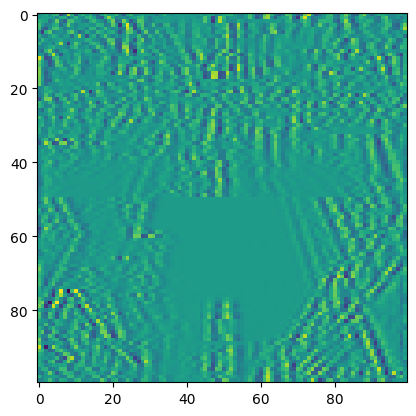

In [3]:
# 'broken_image' 텐서를 2D 형태(100x100)로 변환한 뒤 이미지를 시각화
# - .view(100, 100): 1D 텐서 'broken_image'를 100x100 2D 텐서로 변환
# - plt.imshow(): 2D 배열 데이터를 이미지로 출력 (기본적으로 컬러맵이 적용됨)
plt.imshow(broken_image.view(100,100)) 

In [4]:
def weird_function(x, n_iter=5):
    # 입력 텐서 x를 h에 복사 (h는 연산의 중간 결과를 저장)
    h = x    

    # 필터 정의: [-1/3, 1/3, -1/3]
    filt = torch.tensor([-1./3, 1./3, -1./3])

    for i in range(n_iter):
        zero_tensor = torch.tensor([1.0*0])             # zero_tensor: 텐서 [0] 생성 (가장자리 패딩 역할)
        h_l = torch.cat( (zero_tensor, h[:-1]), 0)      # h의 왼쪽 이동 (맨 앞에 0 추가, 끝 요소 제거)
        h_r = torch.cat((h[1:], zero_tensor), 0 )       # h의 오른쪽 이동 (맨 뒤에 0 추가, 첫 요소 제거)
        h = filt[0] * h + filt[2] * h_l + filt[1] * h_r  # 필터링 수행: 필터 값과 h, h_l, h_r의 가중합

        # 현재 반복이 짝수일 때 h를 두 부분으로 나눠 순서를 재배치
        if i % 2 == 0:
             # h의 절반을 앞뒤로 스왑하여 결합
            h = torch.cat( (h[h.shape[0]//2:],h[:h.shape[0]//2]), 0  )
    return h

In [5]:
def distance_loss(hypothesis, broken_image):    
    # 두 텐서 간의 L2 노름(유클리드 거리)을 계산
    return torch.dist(hypothesis, broken_image)

In [6]:
# random_tensor는 10000개의 원소를 가지는 텐서를 생성
# torch.randn() 함수는 평균이 0, 표준편차가 1인 정규분포를 따르는 난수를 생성
# dtype=torch.float: 텐서의 데이터 타입을 float로 지정
random_tensor = torch.randn(10000, dtype = torch.float)

In [7]:
lr = 0.8    # 학습률을 0.8로 설정
for i in tqdm( range(0,20001) ):   # 0부터 20000까지 반복 (총 20001번 반복)
    # random_tensor 텐서의 requires_grad 속성을 True로 설정하여 기울기 계산을 가능하게 함
    random_tensor.requires_grad_(True)
    # 'random_tensor'를 사용하여 'weird_function'을 통해 예측값(hypothesis)을 계산
    hypothesis = weird_function(random_tensor)
    # 예측값과 손상된 이미지(broken_image) 간의 거리를 계산하여 손실(loss)을 구함
    loss = distance_loss(hypothesis, broken_image)
    # 손실(loss) 값에 대해 역전파(backpropagation)를 수행하여 기울기 계산
    loss.backward()
    # 기울기 계산 후, 'torch.no_grad()' 블록 안에서 파라미터 업데이트 (기울기 계산을 방지)
    with torch.no_grad():
        # 경사 하강법(gradient descent)을 사용하여 'random_tensor'를 업데이트
        random_tensor = random_tensor - lr*random_tensor.grad

    if i % 1000 == 0:  # 1000번마다 손실값을 출력하여 학습 진행 상황
        print('Loss at {} = {}'.format(i, loss.item()))

  0%|          | 0/20001 [00:00<?, ?it/s]

Loss at 0 = 12.387001037597656
Loss at 1000 = 1.1048696041107178
Loss at 2000 = 0.5253157615661621
Loss at 3000 = 0.36674827337265015
Loss at 4000 = 0.2916778028011322
Loss at 5000 = 0.24500668048858643
Loss at 6000 = 0.21107099950313568
Loss at 7000 = 0.18393996357917786
Loss at 8000 = 0.1608535796403885
Loss at 9000 = 0.1403481662273407
Loss at 10000 = 0.12158237397670746
Loss at 11000 = 0.10404352843761444
Loss at 12000 = 0.08740492910146713
Loss at 13000 = 0.07145050913095474
Loss at 14000 = 0.05603305995464325
Loss at 15000 = 0.04105006530880928
Loss at 16000 = 0.026430264115333557
Loss at 17000 = 0.021160222589969635
Loss at 18000 = 0.021166503429412842
Loss at 19000 = 0.021167587488889694
Loss at 20000 = 0.02116791345179081


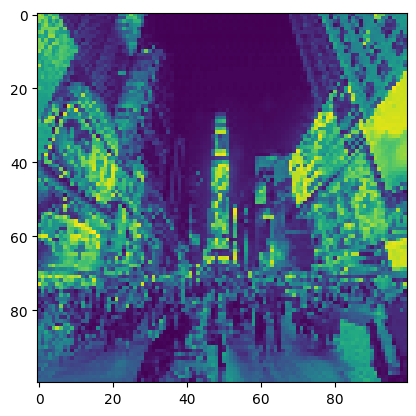

In [8]:
plt.imshow(random_tensor.view(100,100).data)